In [1]:
import numpy as np
import pandas as pd

from neurodsp.sim import sim_synaptic_current, sim_oscillation, sim_bursty_oscillation
from neurodsp.spectral import compute_spectrum
from neurodsp.utils.data import compute_nsamples
from neurodsp.plts import plot_time_series, plot_power_spectra
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from statsmodels.tsa.stattools import acf

from fooof import FOOOF

from timescales.psd import convert_knee_val
from timescales.acf import exp_decay_func
from timescales.sim import sim_poisson_distribution, sim_spike_probs, sim_synaptic_kernel

# Simulation

Here, we simulate a timeseries with a known tau. The knee is simulated at 20hz. A 20hz oscillation is then added to the synaptic current (sig_osc).

These simulations show that acf taus estimation is influenced by the addition of the oscillation, resulting in poor estimations. Whereas the spectral estimation method overcomes the influence of the oscillation.

In [2]:
# Settings
n_seconds = 50
fs = 4000

tau_freq, tau = convert_knee_val(400, 2)
n_neurons = 20
mu = 20

variances = (.8, .2)

In [3]:
# Simulate a synaptic kernel
kernel = sim_synaptic_kernel(5 * tau, fs, 0, tau)

# Pad n_seconds to account for convolution
poisson = sim_poisson_distribution(n_seconds + (len(kernel) * 2),  fs, n_neurons, mu=mu)

# Convovle the poisson with the kernel and rescale to 0-1
probs = sim_spike_probs(n_seconds, fs, poisson, kernel, n_neurons)

sig_no_osc = (probs > np.random.rand(*probs.shape)).sum(axis=0)

In [4]:
# Add an oscillation to the probabilities
for ind in range(len(probs)):
    probs[ind] *= variances[0]
    
# Simulate sine probabilities
sine = sim_oscillation(n_seconds, fs, tau_freq)
probs_sine = (sine - np.min(sine)) / np.ptp(sine)
probs_sine *= variances[1]

for ind in range(len(probs)):
    probs[ind] += probs_sine
    
# Select [0=no spike, 1=spike] using probabilities
sig_osc = (probs < np.random.rand(*probs.shape)).sum(axis=0)

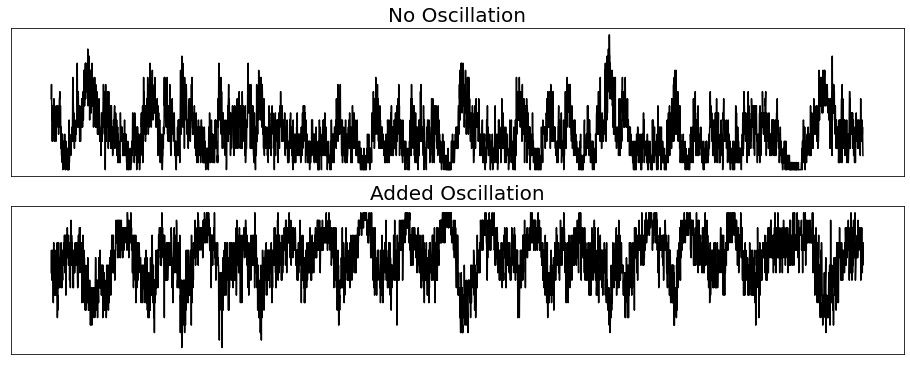

In [5]:
fig, axes = plt.subplots(figsize=(16, 6), nrows=2)
           
axes[0].plot(sig_no_osc[:fs], color='k')
axes[0].set_title('No Oscillation', size=20)

axes[1].plot(sig_osc[:fs], color='k')
axes[1].set_title('Added Oscillation', size=20)

axes[0].set_xticks([])
axes[1].set_xticks([])
axes[0].set_yticks([])
axes[1].set_yticks([])
plt.show()

### SpecParam Tau Estimation

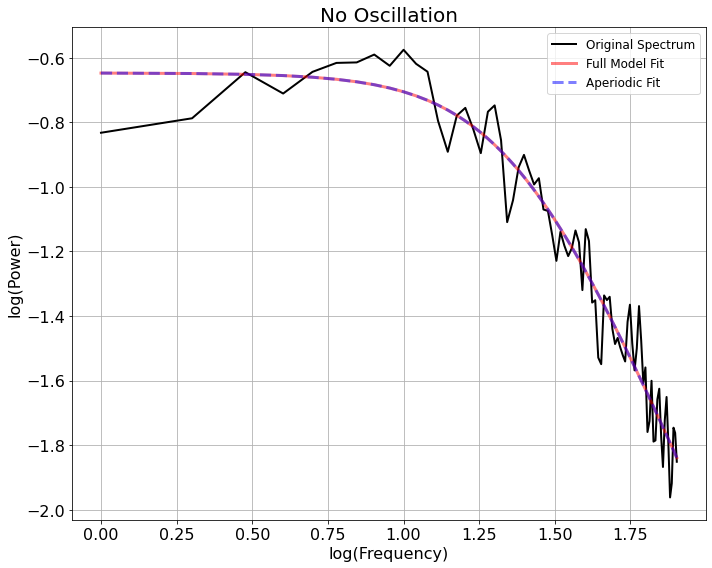

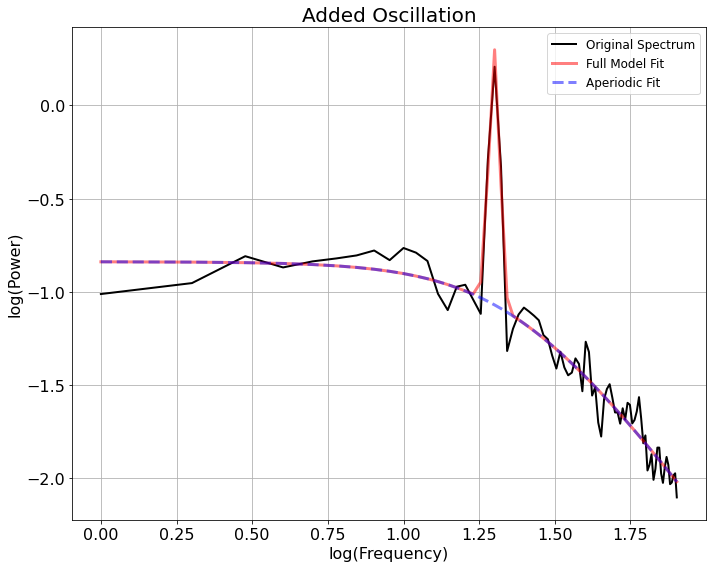

In [6]:
freqs_no_osc, power_no_osc = compute_spectrum(sig_no_osc, fs, f_range=(1, 80))
freqs_osc, power_osc = compute_spectrum(sig_osc, fs, f_range=(1, 80))


fm_no_osc = FOOOF(aperiodic_mode='knee', max_n_peaks=0, verbose=False)
fm_no_osc.fit(freqs_no_osc, power_no_osc, freq_range=(1, 80))
fm_no_osc.plot(plt_log=True, title='No Oscillation')

fm_osc = FOOOF(aperiodic_mode='knee', verbose=False)
fm_osc.fit(freqs_osc, power_osc, freq_range=(1, 80))
fm_osc.plot(plt_log=True, title='Added Oscillation')

In [7]:
# Compute knee freq and tau from the spectral fits
knee_no_osc = fm_no_osc.get_params('aperiodic', 'knee')
exponent_no_osc = fm_no_osc.get_params('aperiodic', 'exponent')
knee_freq_no_osc, knee_tau_no_osc = convert_knee_val(knee_no_osc, exponent_no_osc)

knee_osc = fm_osc.get_params('aperiodic', 'knee')
exponent_osc = fm_osc.get_params('aperiodic', 'exponent')
knee_freq_osc, knee_tau_osc = convert_knee_val(knee_osc, exponent_osc)

### ACF Tau Estimation

In [8]:
# Run and plot ACF
nlags = 500

corrs_no_osc = acf(sig_no_osc, nlags=nlags, qstat=False, fft=True)[1:]
corrs_osc = acf(sig_osc, nlags=nlags, qstat=False, fft=True)[1:]

In [9]:
from neurodsp.sim import sim_damped_oscillation

def damped_cos(xs, freq, gamma, scale):

    cos_damped = sim_damped_oscillation(1, len(xs), freq, gamma)
    
    cos_damped *= scale
    
    return cos_damped

In [10]:
# Fit acf
def fit_acf(fs, tau, corrs, cos=False):

    if cos:
        # Remove oscillatory component of the acf
        #   using a damped cos
        guess = [2.5, .01, .4]  
        bounds = [
            (1, .01, .1),
            (5, .2, 1)
        ]

        xs = np.arange(0, len(corrs_osc))
        params_cos, _ = curve_fit(damped_cos, xs, corrs_osc,
                                  p0=guess, bounds=bounds, maxfev=1000)

        cos = damped_cos(xs, *params_cos)
        
        corrs -= cos
        
    # Fit exponential
    guess = [np.max(corrs), tau*fs, 0.]  

    bounds = [
        (0, 0, -2),
        (2*np.max(corrs), 200, 2)
    ]

    params, _ = curve_fit(exp_decay_func, np.arange(0, len(corrs)), corrs,
                          p0=guess, bounds=bounds, maxfev=1000)

    taus_hat = params[1] / fs
    xs = np.arange(0, len(corrs))
    
    acf_fit = exp_decay_func(xs, *params)
    
    return acf_fit, taus_hat, corrs

fit_no_osc, taus_no_osc, _ = fit_acf(fs, tau, corrs_no_osc.copy())
fit_osc, taus_osc, _ = fit_acf(fs, tau, corrs_osc.copy())
fit_osc_cos, taus_osc_cos, corrs_osc_rm = fit_acf(fs, tau, corrs_osc.copy(), cos=True)

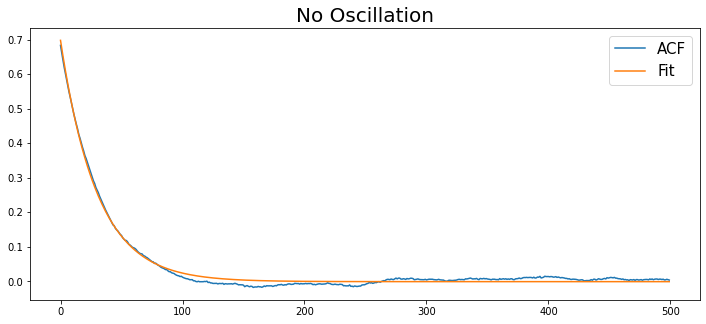

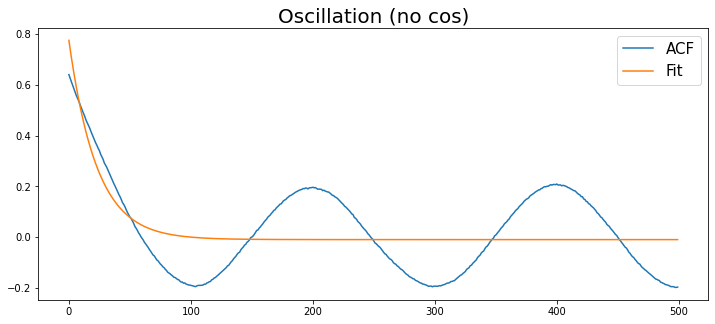

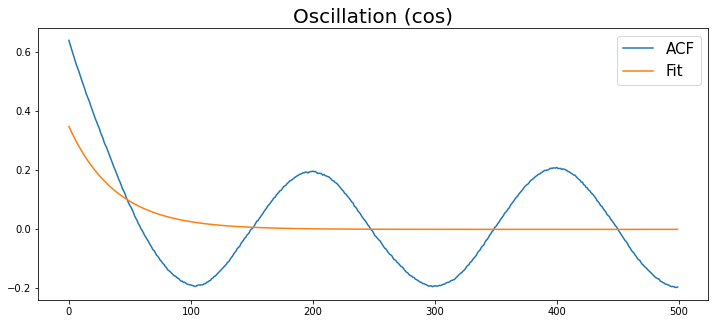

In [11]:
plt.figure(0, figsize=(12, 5))
plt.plot(corrs_no_osc, label='ACF')
plt.plot(fit_no_osc, label='Fit')
plt.title('No Oscillation', size=20)
plt.legend(fontsize=15)
plt.show()

plt.figure(1, figsize=(12, 5))
plt.plot(corrs_osc, label='ACF')
plt.plot(fit_osc, label='Fit')
plt.title('Oscillation (no cos)', size=20)
plt.legend(fontsize=15)
plt.show()

plt.figure(1, figsize=(12, 5))
plt.plot(corrs_osc, label='ACF')
plt.plot(fit_osc_cos, label='Fit')
plt.title('Oscillation (cos)', size=20)
plt.legend(fontsize=15)
plt.show()

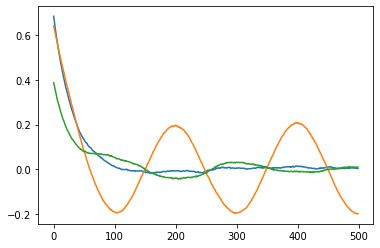

In [12]:
plt.plot(corrs_no_osc)
plt.plot(corrs_osc)
plt.plot(corrs_osc_rm)

## Results

The results from ACF estimation vs spectral estimation of the synaptic current vs synaptic current with oscillation are compared below. Not

In [13]:
df = pd.DataFrame()

df['fit'] = ['Simulated', 'ACF No Osc', 'ACF Osc', 'ACF Osc (cos)', 'Spec No Osc', 'Spec Osc']
df['tau'] = [tau, taus_no_osc, taus_osc, taus_osc_cos, knee_tau_no_osc, knee_tau_osc]

df

,fit,tau
0,Simulated,0.007958
1,ACF No Osc,0.007486
2,ACF Osc,0.005696
3,ACF Osc (cos),0.009626
4,Spec No Osc,0.006643
5,Spec Osc,0.006770
